In [16]:
pip install pandas scikit-learn openpyxl matplotlib seaborn numpy==1.26.0 statsmodels catboost

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [18]:
df = pd.read_excel("train.xlsx")  
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [19]:
df.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [20]:
 # Преобразуем колонку с датой в формат datetime
df['dt'] = pd.to_datetime(df['dt'])

# Убеждаемся, что данные отсортированы по времени
df = df.sort_values(by='dt')


# Добавляем новые признаки
df["year"] = df["dt"].dt.year
df["month"] = df["dt"].dt.month
df["quarter"] = df["dt"].dt.quarter
df["day_of_month"] = df["dt"].dt.day
df["day_of_week"] = df["dt"].dt.weekday 

df = df.copy()


In [21]:
df.set_index('dt', inplace=True)

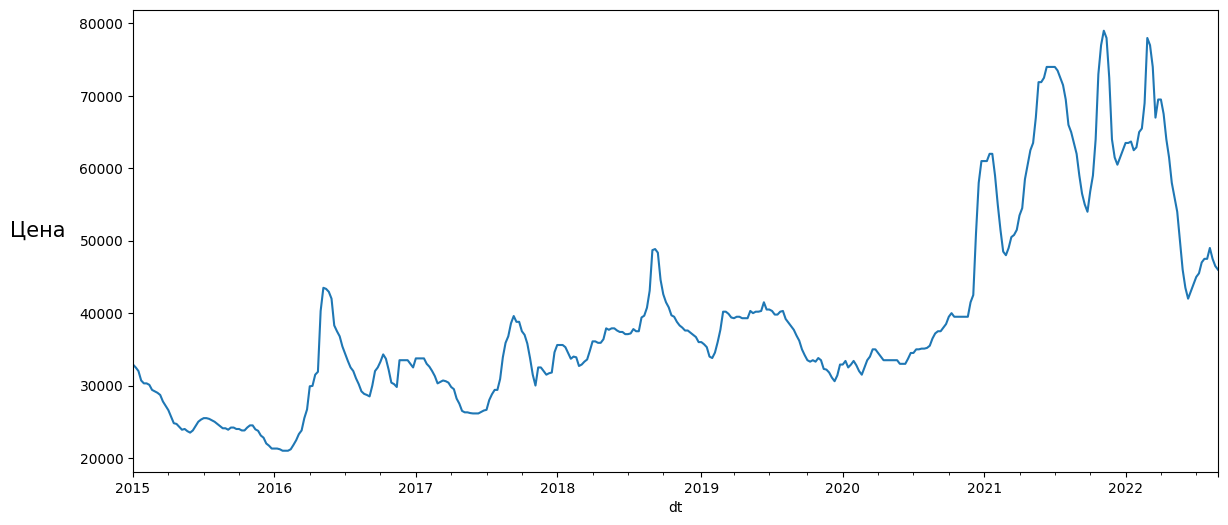

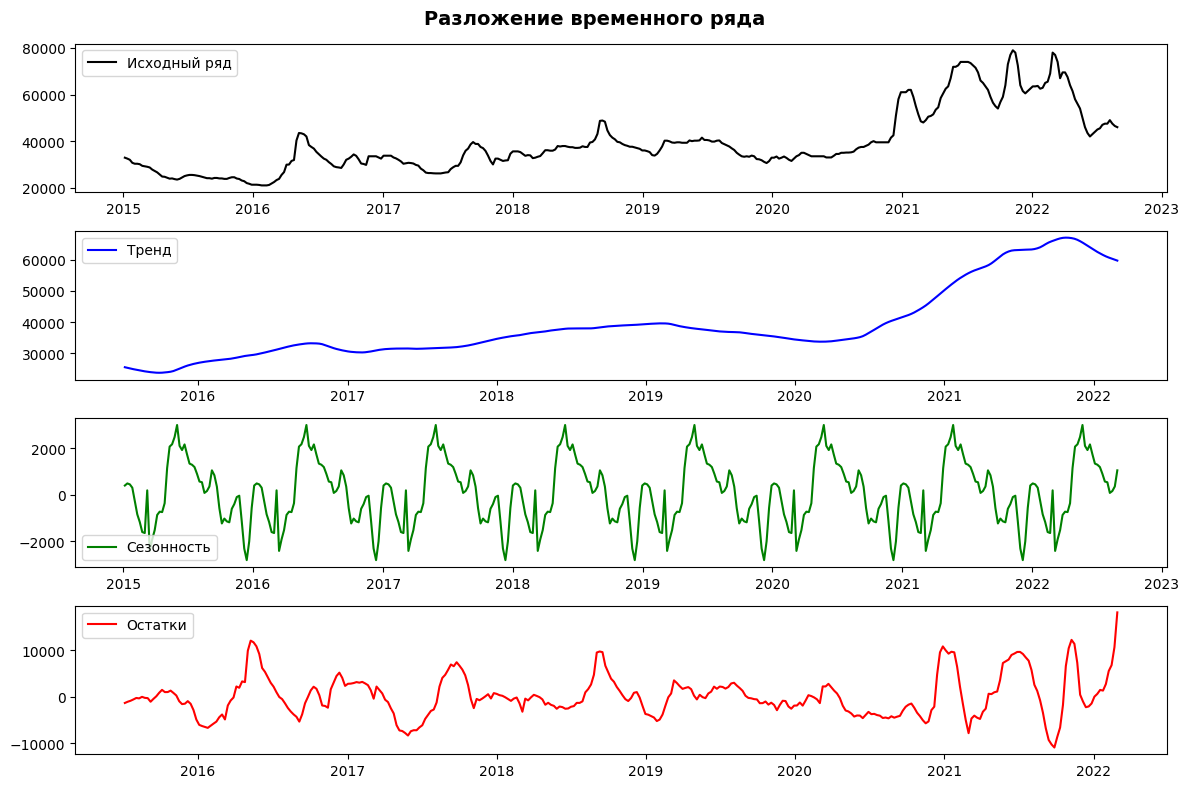

In [22]:
# Разложение временного ряда
decomposition = seasonal_decompose(df['Цена на арматуру'], model='additive', period=52)  # период ~1 год



# Рассмотрим изменение цены
plt.figure(figsize=(14, 6))
# plt.title('Time series example')
# plt.xlabel('Date', fontsize=15)
plt.ylabel('Цена', rotation=0, labelpad=30, fontsize=15)
df['Цена на арматуру'].plot();

plt.figure(figsize=(12, 8))
plt.suptitle("Разложение временного ряда", fontsize=14, fontweight='bold')

plt.subplot(4, 1, 1)
plt.plot(df['Цена на арматуру'], label='Исходный ряд', color='black')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Тренд', color='blue')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Сезонность', color='green')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Остатки', color='red')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series):
    """
    Функция для проверки стационарности временного ряда с помощью теста Дики-Фуллера.
    
   
    """
    result = adfuller(series.dropna())  # Тест ADF, удаляем NaN перед проверкой
    print("Результаты теста Дики-Фуллера:")
    print(f"ADF-статистика: {result[0]:.4f}")
    print(f"p-значение: {result[1]:.4f}")
    print("Критические значения:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    
    # Интерпретация результатов
    if result[1] <= 0.05:
        print("\n✅ Ряд стационарен (отвергаем нулевую гипотезу о наличии единичного корня).")
    else:
        print("\n❌ Ряд НЕ стационарен (не отвергаем нулевую гипотезу).")

# Проверяем стационарность исходного ряда
test_stationarity(df['Цена на арматуру'])


Результаты теста Дики-Фуллера:
ADF-статистика: -1.9259
p-значение: 0.3200
Критические значения:
   1%: -3.4471
   5%: -2.8689
   10%: -2.5707

❌ Ряд НЕ стационарен (не отвергаем нулевую гипотезу).


In [24]:
import numpy as np
import pandas as pd

# Определяем окно скользящего стандартного отклонения
window = 12  # Например, 12 для месячных данных

# Копируем данные, чтобы не изменять оригинальный DataFrame
df_transformed = df.copy()

# Вычисляем скользящее стандартное отклонение
df_transformed['rolling_std'] = df_transformed['Цена на арматуру'].rolling(window=window).std()

# Нормализуем ряд, деля на скользящее стандартное отклонение
df_transformed['normalized_price'] = df_transformed['Цена на арматуру'] / df_transformed['rolling_std']

# Логарифмируем нормализованный ряд (добавляем небольшую константу, чтобы избежать log(0))
df_transformed['log_normalized_price'] = np.log(df_transformed['normalized_price'] + 1e-10)

# Дифференцируем логарифмированный ряд
df_transformed['stationary_price'] = df_transformed['log_normalized_price'].diff()

# Удаляем пропущенные значения, возникшие после вычислений
df_transformed = df_transformed.dropna()

# Выводим обработанный DataFrame
df_transformed


,Цена на арматуру,year,month,quarter,day_of_month,day_of_week,rolling_std,normalized_price,log_normalized_price,stationary_price
dt,,,,,,,,,,
2015-03-30,27200,2015,3,1,30,0,1556.413905,17.476071,2.860833,-0.012110
2015-04-06,26600,2015,4,2,6,0,1546.329966,17.202021,2.845027,-0.015806
2015-04-13,25700,2015,4,2,13,0,1605.388653,16.008585,2.773125,-0.071902
2015-04-20,24800,2015,4,2,20,0,1840.186914,13.476892,2.600977,-0.172149
2015-04-27,24700,2015,4,2,27,0,1980.109425,12.474058,2.523651,-0.077325
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,47500,2022,8,3,1,0,3320.049288,14.307017,2.660750,0.271592
2022-08-08,49000,2022,8,3,8,0,2461.829820,19.903894,2.990915,0.330165
2022-08-15,47500,2022,8,3,15,0,2165.063509,21.939310,3.088280,0.097365


In [25]:
from statsmodels.tsa.stattools import adfuller

# Применяем тест Дики-Фуллера к преобразованному ряду
result = adfuller(df_transformed['normalized_price'])

# Выводим результаты теста
print("Результаты теста Дики-Фуллера:")
print(f"ADF-статистика: {result[0]:.4f}")
print(f"p-значение: {result[1]:.4f}")
print("Критические значения:")
for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")

# Интерпретация результата
if result[1] < 0.05:
    print("\n✅ Временной ряд стационарен (отклоняем нулевую гипотезу).")
else:
    print("\n❌ Временной ряд не является стационарным (не можем отклонить нулевую гипотезу).")


Результаты теста Дики-Фуллера:
ADF-статистика: -5.2016
p-значение: 0.0000
Критические значения:
   1%: -3.4474
   5%: -2.8691
   10%: -2.5708

✅ Временной ряд стационарен (отклоняем нулевую гипотезу).


In [26]:
df_transformed.to_csv("stdanie.csv", index=True)

In [27]:
# Загрузка данных
df = pd.read_csv('danie.csv', parse_dates=['dt'], index_col='dt')

# Выбор целевой переменной
target = df['Цена на арматуру'].dropna()

# Проверка стационарности (например, с помощью теста Дики-Фуллера)
from statsmodels.tsa.stattools import adfuller
result = adfuller(target)
print(f"ADF p-value: {result[1]:.4f}")  # Если p-value > 0.05, ряд нестационарен

ADF p-value: 0.0000


C:\Users\User\AppData\Local\Temp\ipykernel_12584\1060838573.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['trend'].interpolate(inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_12584\1060838573.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when 

0:	learn: 0.0933648	test: 0.0649230	best: 0.0649230 (0)	total: 626us	remaining: 626ms
100:	learn: 0.0090463	test: 0.0062795	best: 0.0062788 (99)	total: 48.9ms	remaining: 435ms
200:	learn: 0.0042838	test: 0.0043078	best: 0.0043078 (200)	total: 100ms	remaining: 399ms
300:	learn: 0.0029035	test: 0.0033084	best: 0.0033084 (300)	total: 144ms	remaining: 334ms
400:	learn: 0.0022186	test: 0.0028543	best: 0.0028543 (400)	total: 201ms	remaining: 301ms
500:	learn: 0.0018582	test: 0.0026681	best: 0.0026681 (500)	total: 245ms	remaining: 244ms
600:	learn: 0.0015801	test: 0.0025302	best: 0.0025302 (600)	total: 288ms	remaining: 191ms
700:	learn: 0.0013991	test: 0.0024853	best: 0.0024846 (698)	total: 329ms	remaining: 140ms
800:	learn: 0.0012474	test: 0.0024483	best: 0.0024470 (797)	total: 371ms	remaining: 92.2ms
900:	learn: 0.0011285	test: 0.0024207	best: 0.0024200 (893)	total: 416ms	remaining: 45.7ms
999:	learn: 0.0010252	test: 0.0023938	best: 0.0023929 (993)	total: 463ms	remaining: 0us

bestTest = 0.

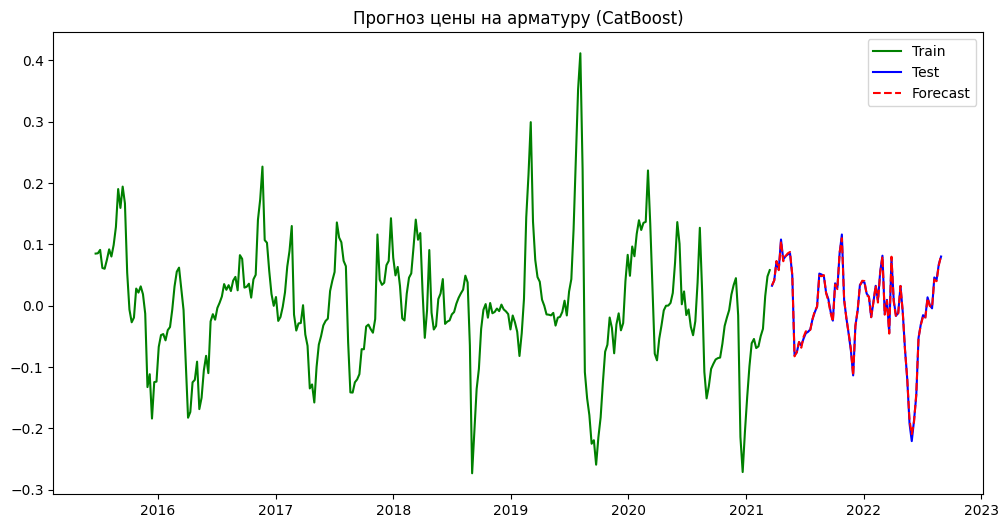

In [35]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

# Добавим разложение на тренд и сезонность
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['Цена на арматуру'], model='additive', period=52)
df['trend'] = decomposition.trend
df['seasonal'] = decomposition.seasonal

# Заполним пропущенные значения (например, методом линейной интерполяции)
df['trend'].interpolate(inplace=True)
df['seasonal'].interpolate(inplace=True)

# Разделим данные на train и test
X = df[['Цена на арматуру', 'trend', 'seasonal']]
y = df['Цена на арматуру']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Обновленные параметры CatBoostRegressor
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=1000,  # Уменьшено с 1000 до 500
    learning_rate=0.05,  # Снижен learning_rate
    depth=4,
    loss_function='RMSE',
    l2_leaf_reg=3.0,  # Добавлена L2-регуляризация
    early_stopping_rounds=50,  # Ранняя остановка
    verbose=100
)

# Обучение модели
model.fit(X_train, y_train, eval_set=(X_test, y_test))


# Прогнозирование
predictions = model.predict(X_test)

# Оценка модели
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(X_train.index, y_train, label='Train', color='green')
plt.plot(X_test.index, y_test, label='Test', color='blue')
plt.plot(X_test.index, predictions, label='Forecast', color='red', linestyle='--')
plt.title('Прогноз цены на арматуру (CatBoost)')
plt.legend()
plt.show()
